In [3]:
%pip install pandas matplotlib scikit-learn seaborn xgboost > Nul

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, roc_curve

# Обзор статьи Detection of illicit accounts over the ETheum blockchain

> Данный обзор содержит данные из [статьи](https://pure.rug.nl/ws/portalfiles/portal/127068391/1_s2.0_S0957417420301433_main.pdf#page=5&zoom=100,0,978). Она посвящена разбору AML алгоритма(определения является ли адрес в сети Ethereum мошенническим или нет) на основании собранных данных и подобранной модели машинного обучения


## Введение
Переход к децентрализованным цифровым активам привел к быстрому развитию криптовалют, которые стремятся предложить более широкий спектр возможностей, чем просто перевод средств между счетами.

В 2013 году [Виталик Бутерин](https://ru.wikipedia.org/wiki/%D0%91%D1%83%D1%82%D0%B5%D1%80%D0%B8%D0%BD,_%D0%92%D0%B8%D1%82%D0%B0%D0%BB%D0%B8%D0%BA) предложил блокчейн [Ethereum](https://ethereum.org/), который удовлетворил эту потребность, представив концепцию смарт-контрактов. Эта концепция, в сочетании с повышенной безопасностью блокчейн технологии, децентрализацией вычислительной логики и огромным сообществом разработчиков в области криптовалют, продемонстрировала потенциал широкого применения.

Однако криптовалютные сети, включая Ethereum, подвержены воздействию лиц, осуществляющих незаконную деятельность в сети.

Анонимность в сети определена как одна из фундаментальных особенностей блокчейн систем, но некоторые пользователи злоупотребляют этой функциональностью для противоправных действий. Это подрывает доверие обычных пользователей и оказывает негативное влияние на сеть. В силу децентрализованной природы Ethereum, никто не вправе блокировать отдельных пользователей. Однако для борьбы с противоправными действиями в сети были разработаны методологии и методы обнаружения подобных операций.

## Особенности применяемых данных, моделей и методов

### Алгоритм машинного обучения
Основой данного AML алгоритма является модель машинного обучения __XGBoost__.

### Данные для обучения
Набор данных был получен путем объединения нескольких источников:
* [Etherscamdb](https://github.com/MrLuit/EtherScamDB) - база данных с открытым исходным кодом для отслеживания мошенничества в сети ETheum.
* [Etherscan](https://etherscan.io/) - обозреватель блокчейна Ethereum
* [Geth](https://geth.ethereum.org/) - реализация Ethereum на Go, шлюз в децентрализованную сеть.

Все незаконные учетные записи, были собраны из Etherscamdb(Более подробно можно ознакомится в файле `./etherscamdb/addresses-darklist.json`).

Учетные записи были отмечены сообществом Ethereum за незаконное поведение в ряде случаев:
* Попытка имитировать адреса других контрактов, предоставляющих токены
* Мошеннические лотереи
* Имитация других пользователей
* Фишинговые и зеркальные веб-сайты

Всего было взято 2179 мошеннических аккаунтов. На этапе подготовки данных не требовалось никакой предварительной обработки, поскольку не требовалось никаких пропущенных значений и преобразований.

Для сбора обычных учетных записей - случайным образом были выбраны 3000 обычных учетных записей, которые проводили транзакции в диапазоне блоков 3 800 000 и 3 805 000,5. После фильтрации неуникальных учетных записей окончательное количество составило 2 502 уникальных. Эти учетные записи были активны в середине июля 2017 года — в период, когда наблюдался рост использования сети Ethereum. Все учетные записи были сопоставлены с идентификаторами незаконных учетных записей, чтобы гарантировать, что ни одна из полученных учетных записей не осуществляла незаконную деятельность.


Общее количество всех собранных аккаунтов составило 4681.

Затем данные адресов учетных записей передавались в Etherscan для получения всех соответствующих транзакций, в которых участвовала учетная запись. 


API Etherscan поддерживает извлечение только последних 10 000 транзакций, выполненных с контрактами с интерфейсом ERC20 или внешним счетом.

После извлечения всех статистических данных из транзакций, они были добавлены CSV файл для классификации модели(Более подробно можно ознакомится в файле `./complete.csv`).

Итак, вот признаки фигурирующие для обучения модели:
1. Avg_min_between_sent_tnx - Среднее время между отправленными транзакциями в минутах
2. Avg_min_between_received_tnx - Среднее время между полученными транзакциями в минутах
3. Time_Diff_between_first_and_last(Mins) - Разница во времени между первой и последней транзакцией в минутах
4. Sent_tnx - Общее количество отправленных обычных транзакций
5. Received_tnx - Общее количество полученных обычных транзакций
6. Number_of_Created_Contracts - Общее количество транзакций для создания смарт-контрактов
7. Unique_Received_From_Addresses - Общее количество уникальных адресов, от которых аккаунт получил транзакции
8. Unique_Sent_To_Addresses - Общее количество уникальных адресов, на которые аккаунт отправил транзакции

9. Min_Value_Received - Минимальное значение в Eth, когда-либо полученное
10. Max_Value_Received - Максимальное значение в Eth, когда-либо полученное
11. Avg_Value_Received - Среднее значение в Eth, полученное аккаунтом

12. Min_Val_Sent - Минимальное значение в Eth, когда-либо отправленное
13. Max_Val_Sent - Максимальное значение в Eth, когда-либо отправленное
14. Avg_Val_Sent - Среднее значение в Eth, отправленное аккаунтом

15. Min_Value_Sent_To_Contract - Минимальное значение в Eth, отправленное контракту
16. Max_Value_Sent_To_Contract - Максимальное значение в Eth, отправленное контракту
17. Avg_Value_Sent_To_Contract - Среднее значение в Eth, отправленное контрактам

18. Total_Transactions(Including_Tnx_to_Create_Contract) - Общее количество транзакций, включая транзакции на создание контракта

19. Total_Ether_Sent - Общее количество отправленного Eth
20. Total_Ether_Received - Общее количество полученного Eth
21. Total_Ether_Sent_Contracts - Общее количество отправленного Eth на адреса контрактов
22. Total_Ether_Balance - Общий баланс в Eth после выполненных транзакций

23. Total_ERC20_Tnxs - Общее количество транзакций связанных с контрактами которые наследуются от стандарта ERC20

24. ERC20_Total_Ether_Received - Общее количество полученных токенов ERC20
25. ERC20_Total_Ether_Sent - Общее количество Eth отправленных токенов ERC20
26. ERC20_Total_Ether_Sent_Contract - Общее количество Eth отправленных токенов ERC20 _смарт-контрактам_

27. ERC20_Uniq_Sent_Addr - Количество уникальных адресов кошельков которым аккаунт с нашей стороны отправлял транзакций используя смарт-контракт который наследуется от стандарта ERC20
28. ERC20_Uniq_Rec_Addr - Количество уникальных адресов кошельков от которых аккаунт с нашей стороны получил транзакции в которых участвовал смарт-контракт который наследуется от стандарта ERC20
29. ERC20_Uniq_Rec_Contract_Addr - Количество уникальных адресов смарт-контрактов от которых аккаунт с нашей стороны получил транзакции в которых участвовал смарт-контракт который наследуется от стандарта ERC20

30. ERC20_Avg_Time_Between_Sent_Tnx - Среднее время между отправленными транзакциями в которых участвовал смарт-контракт который наследуется от стандарта ERC20 в минутах
31. ERC20_Avg_Time_Between_Rec_Tnx - Среднее время между полученными транзакциями в которых участвовал смарт-контракт который наследуется от стандарта ERC20 в минутах
32. ERC20_Avg_Time_Between_Contract_Tnx - Среднее время между отправленными транзакциями _контрактам_ в которых участвовал смарт-контракт который наследуется от стандарта ERC20 в минутах

33. ERC20_Min_Val_Rec - Минимальное количество полученных токенов ERC20
34. ERC20_Max_Val_Rec - Максимальное количество полученных токенов ERC20
35. ERC20_Avg_Val_Rec - Среднее количество полученных токенов ERC20

36. ERC20_Min_Val_Sent - Минимальное количество отправленных токенов ERC20
37. ERC20_Max_Val_Sent - Максимальное количество отправленных токенов ERC20
38. ERC20_Avg_Val_Sent - Среднее количество отправленных токенов ERC20

39. ERC20_Uniq_Sent_Token_Name - Количество уникальных отправленных токенов ERC20
40. ERC20_Uniq_Rec_Token_Name - Количество уникальных полученных токенов ERC20

41. ERC20_Most_Sent_Token_Type - Наиболее часто отправляемый токен ERC20
42. ERC20_Most_Rec_Token_Type - Наиболее часто получаемый токен ERC20


Информация о полях и типах данных содержащихся в таблице

In [5]:
data = pd.read_csv("./data/complete.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4681 entries, 0 to 4680
Data columns (total 45 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Index                                                  4681 non-null   int64  
 1   Address                                                4681 non-null   object 
 2   FLAG                                                   4681 non-null   int64  
 3   Avg_min_between_sent_tnx                               4681 non-null   float64
 4   Avg_min_between_received_tnx                           4681 non-null   float64
 5   Time_Diff_between_first_and_last_(Mins)                4681 non-null   float64
 6   Sent_tnx                                               4681 non-null   int64  
 7   Received_Tnx                                           4681 non-null   int64  
 8   Number_of_Created_Contracts                     

In [11]:
def remove_fields(df: pd.DataFrame):
    df.pop('Index')
    df.pop('Address')
    df.pop('ERC20_most_sent_token_type')
    df.pop('ERC20_most_rec_token_type')
    df.pop('ERC20_uniq_sent_token_name')
    df.pop('ERC20_uniq_rec_token_name')
    return df

def get_normal_dataset(df: pd.DataFrame):
    df = remove_fields(df)
    df.fillna(0, inplace=True)
    return df

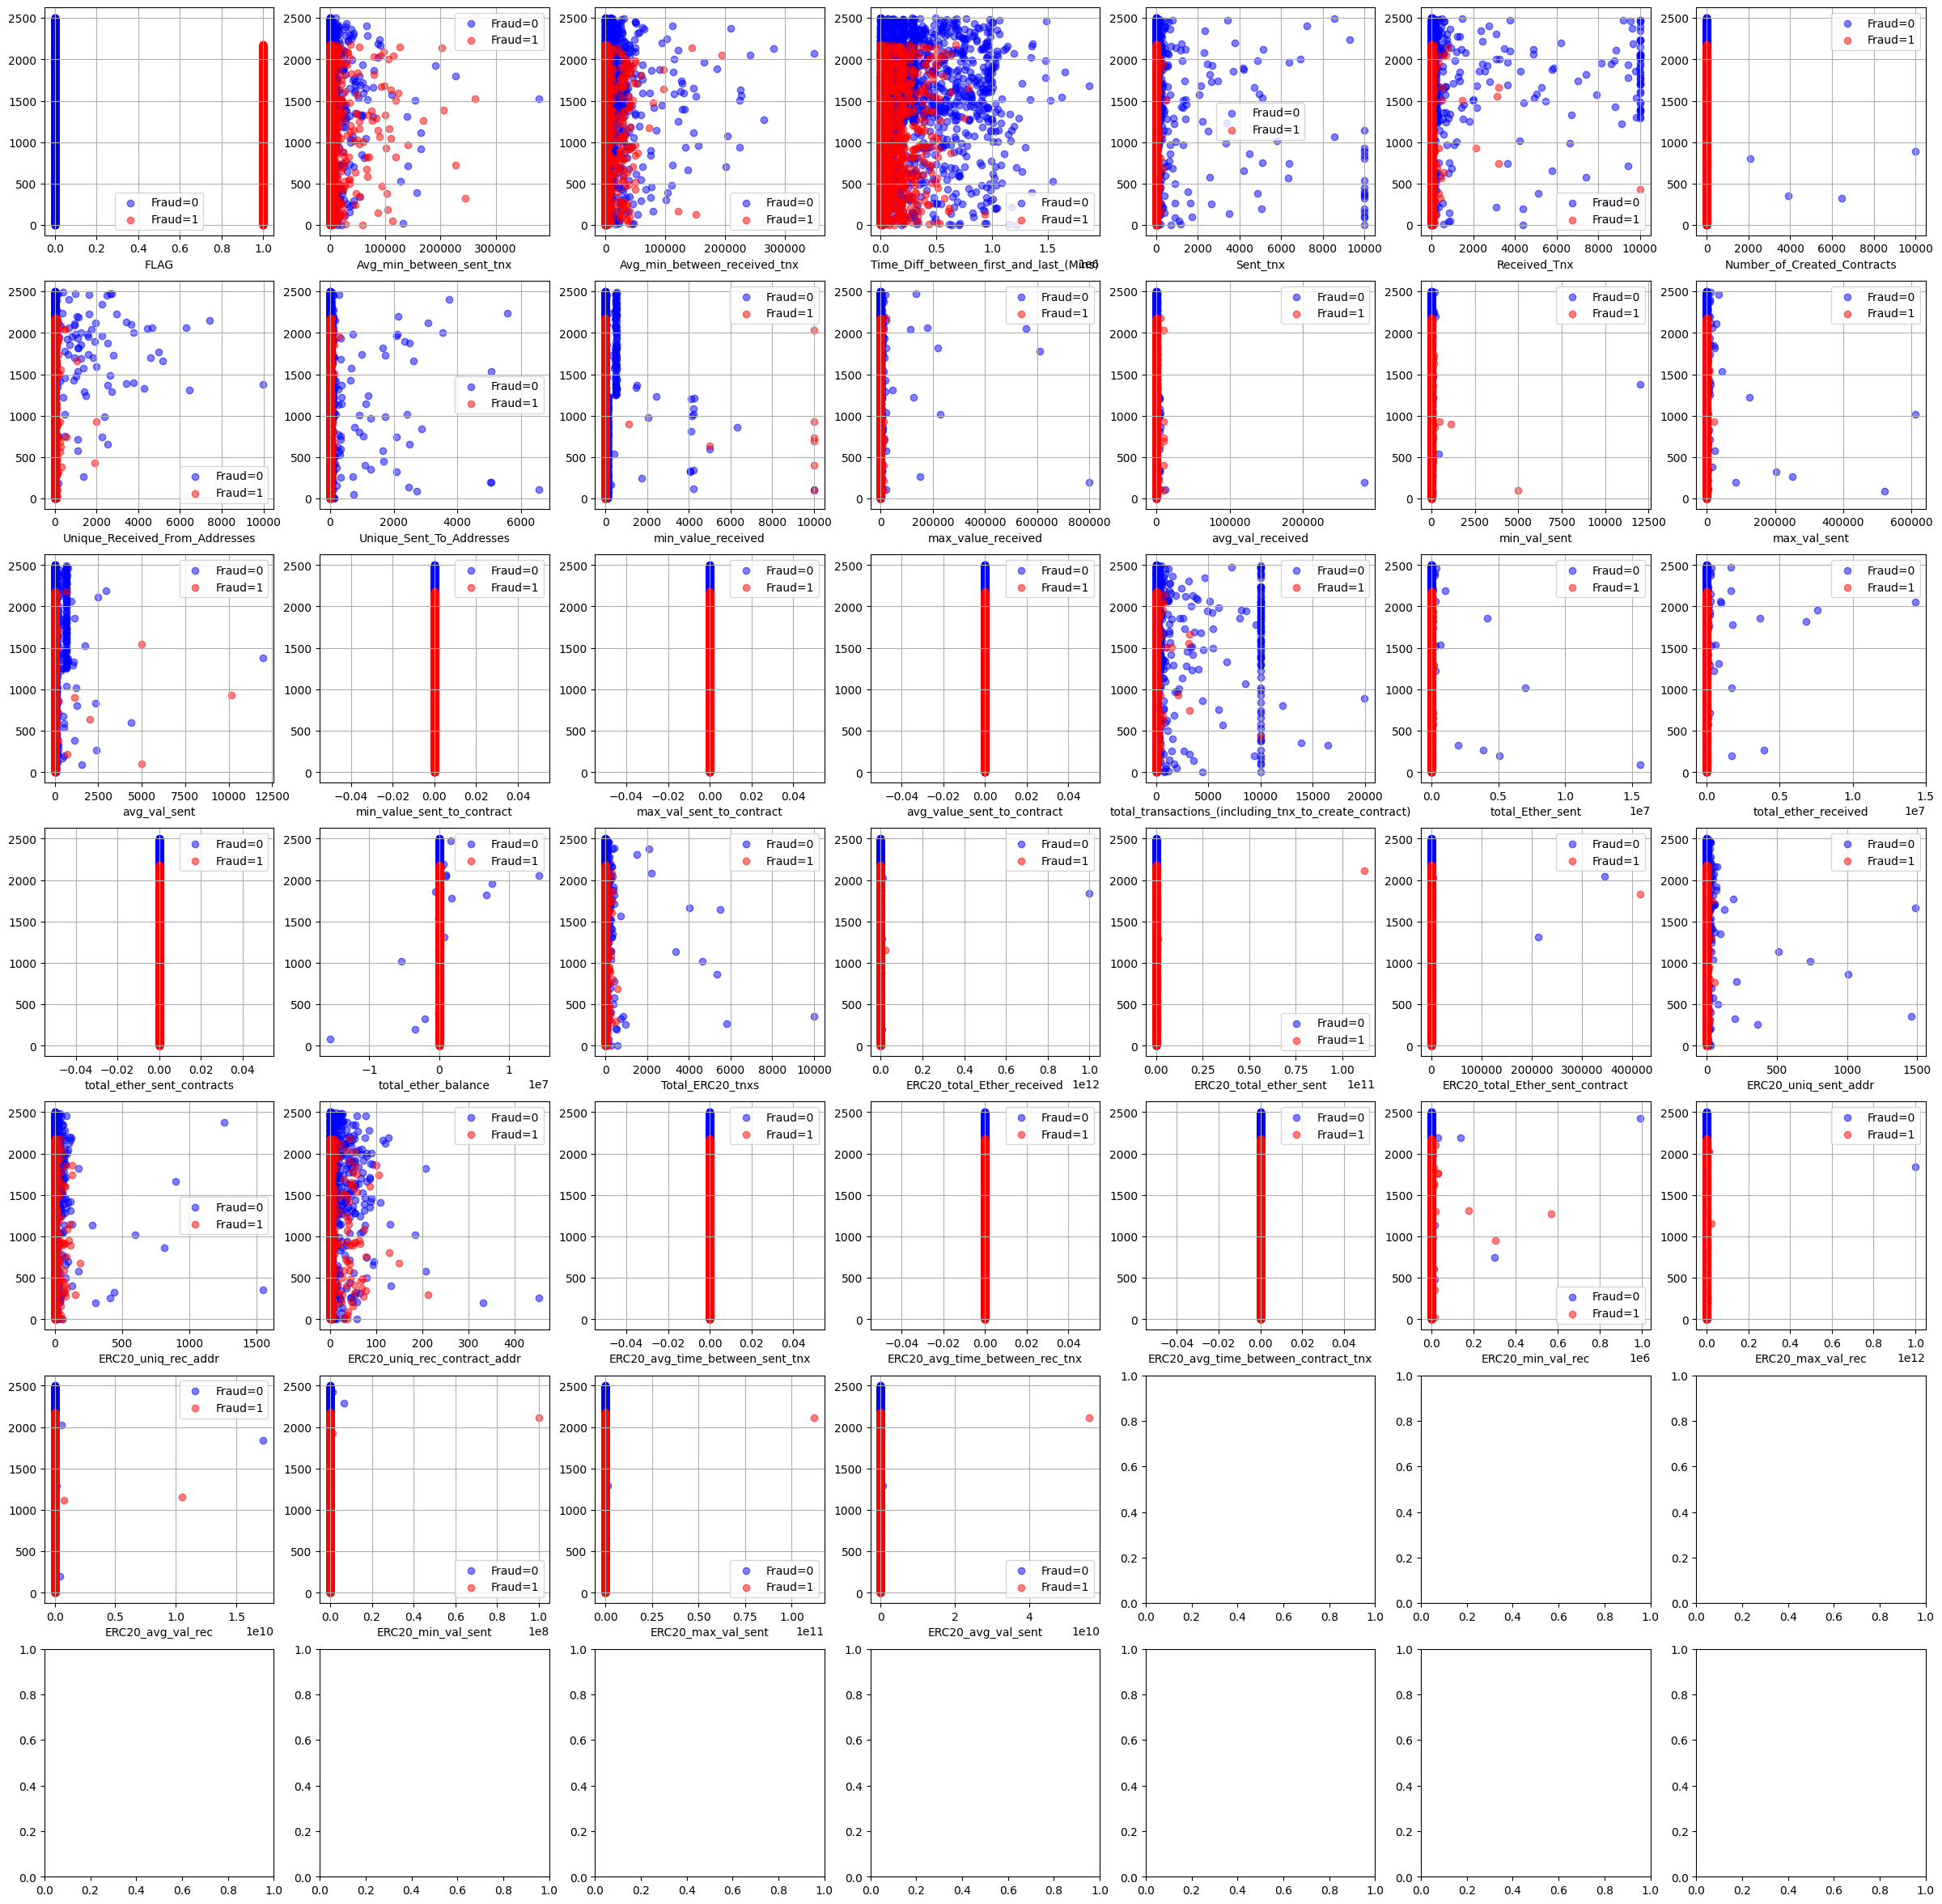

In [15]:
def compare_all_feat(data: pd.DataFrame):
    nrows = round(np.sqrt(len(data.columns)))+1
    ncols = nrows

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_figheight(30)
    fig.set_figwidth(30)

    colors = {0: 'blue', 1: 'red'}

    for i, column_name in enumerate(data.columns):
        row = i // ncols
        col = i % ncols
        
        for fraud_value in [0, 1]:
            indices = data['FLAG'] == fraud_value
            axs[row, col].scatter(data[column_name][indices], range(len(data[column_name][indices])), color=colors[fraud_value], label=f'Fraud={fraud_value}', alpha=0.5)

        axs[row, col].grid(True)
        axs[row, col].set_xlabel(column_name)
        axs[row, col].legend()

    plt.show()
compare_all_feat(get_normal_dataset(data.copy()))

### Графическое представление данных
Для графического представления данных используется нелинейное преобразование, применяющееся к исходному пространству объектов с использованием t-SNE.

[t-SNE](https://neerc.ifmo.ru/wiki/index.php?title=%D0%A1%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%B2%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D0%BE%D1%81%D0%B5%D0%B4%D0%B5%D0%B9_%D1%81_t-%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC) - это метод визуализации данных высокой размерности с помощью представления каждой точки данных в двух или трехмерном пространстве, являющийся модификацией метода стохастического вложения соседей.

In [16]:
data_for_tsne = get_normal_dataset(data.copy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4681 samples in 0.001s...
[t-SNE] Computed neighbors for 4681 samples in 0.197s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4681
[t-SNE] Computed conditional probabilities for sample 2000 / 4681
[t-SNE] Computed conditional probabilities for sample 3000 / 4681
[t-SNE] Computed conditional probabilities for sample 4000 / 4681
[t-SNE] Computed conditional probabilities for sample 4681 / 4681
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.100441
[t-SNE] KL divergence after 1000 iterations: 0.420555


C:\Users\Max\AppData\Local\Temp\ipykernel_22304\3494792102.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


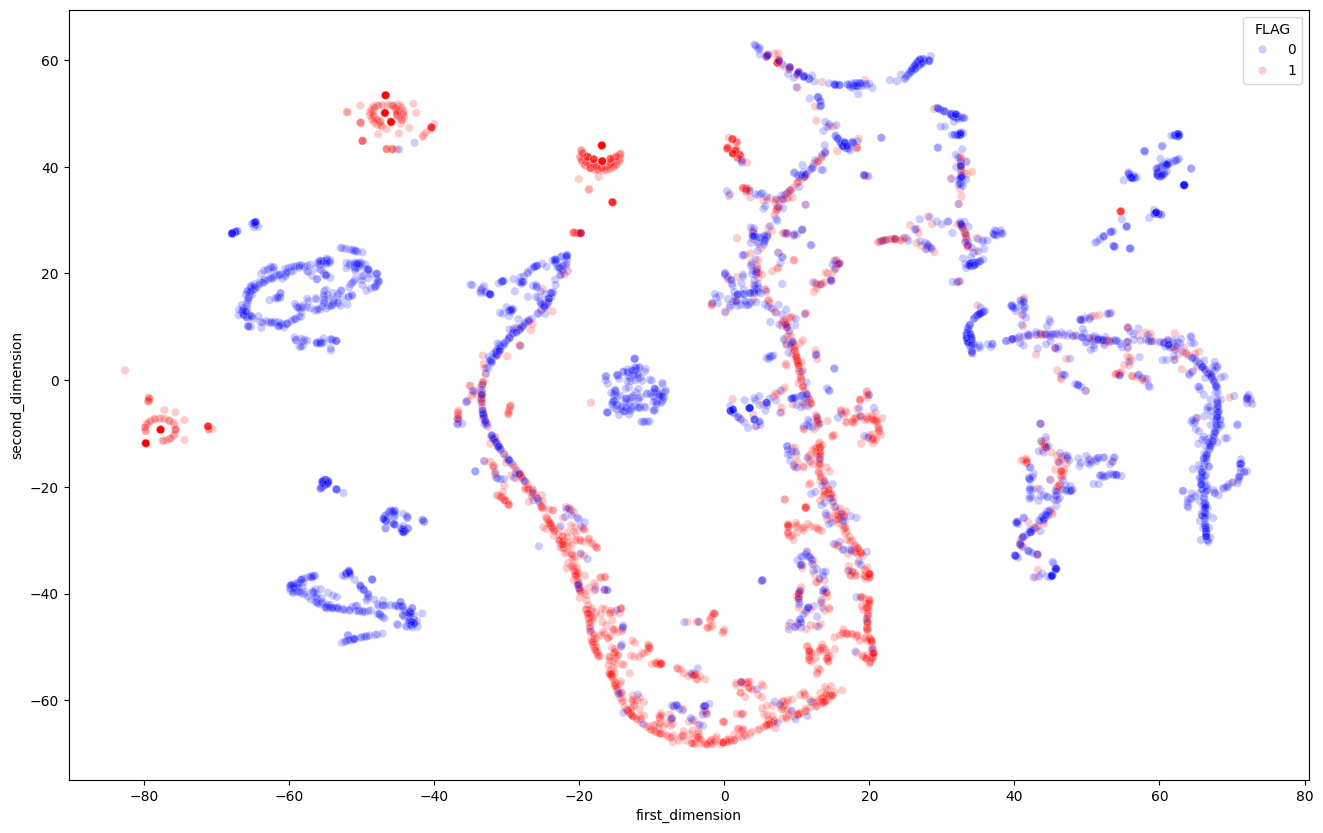

In [5]:
# Оригинальный код представлен https://github.com/sfarrugia15/Ethereum_Fraud_Detection/blob/7c71cb8d103e94e8d441463803b96a4b80de0f96/Account_Stats/Account_Clustering.py#L80

def TSNE_plot_2D(df):
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, n_iter_without_progress=20)
    
    X = df.loc[:, df.columns != 'FLAG']
    Y = df['FLAG']
    
    tsne_results = tsne.fit_transform(X)
    
    X['first_dimension'] = tsne_results[:, 0]
    X['second_dimension'] = tsne_results[:, 1]
    
    fig = plt.figure(figsize=(16, 10))
    
    sns.scatterplot(
        x="first_dimension", y="second_dimension",
        hue=Y,
        palette=['blue','red'],
        data=X,
        legend="full",
        alpha=0.2
    )
    
    fig.show()

TSNE_plot_2D(data_for_tsne)


На двумерной диаграмме рассеяния мы наблюдаем несколько различимых кластеров из обоих классов, в частности, три красных кластера, расположенных в верхней левой части графика. Тем не менее, всё ещё существует значительное перекрытие точек данных разных классов, присутствующих повсюду.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4681 samples in 0.000s...
[t-SNE] Computed neighbors for 4681 samples in 0.122s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4681
[t-SNE] Computed conditional probabilities for sample 2000 / 4681
[t-SNE] Computed conditional probabilities for sample 3000 / 4681
[t-SNE] Computed conditional probabilities for sample 4000 / 4681
[t-SNE] Computed conditional probabilities for sample 4681 / 4681
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.274296
[t-SNE] KL divergence after 1000 iterations: 0.336411


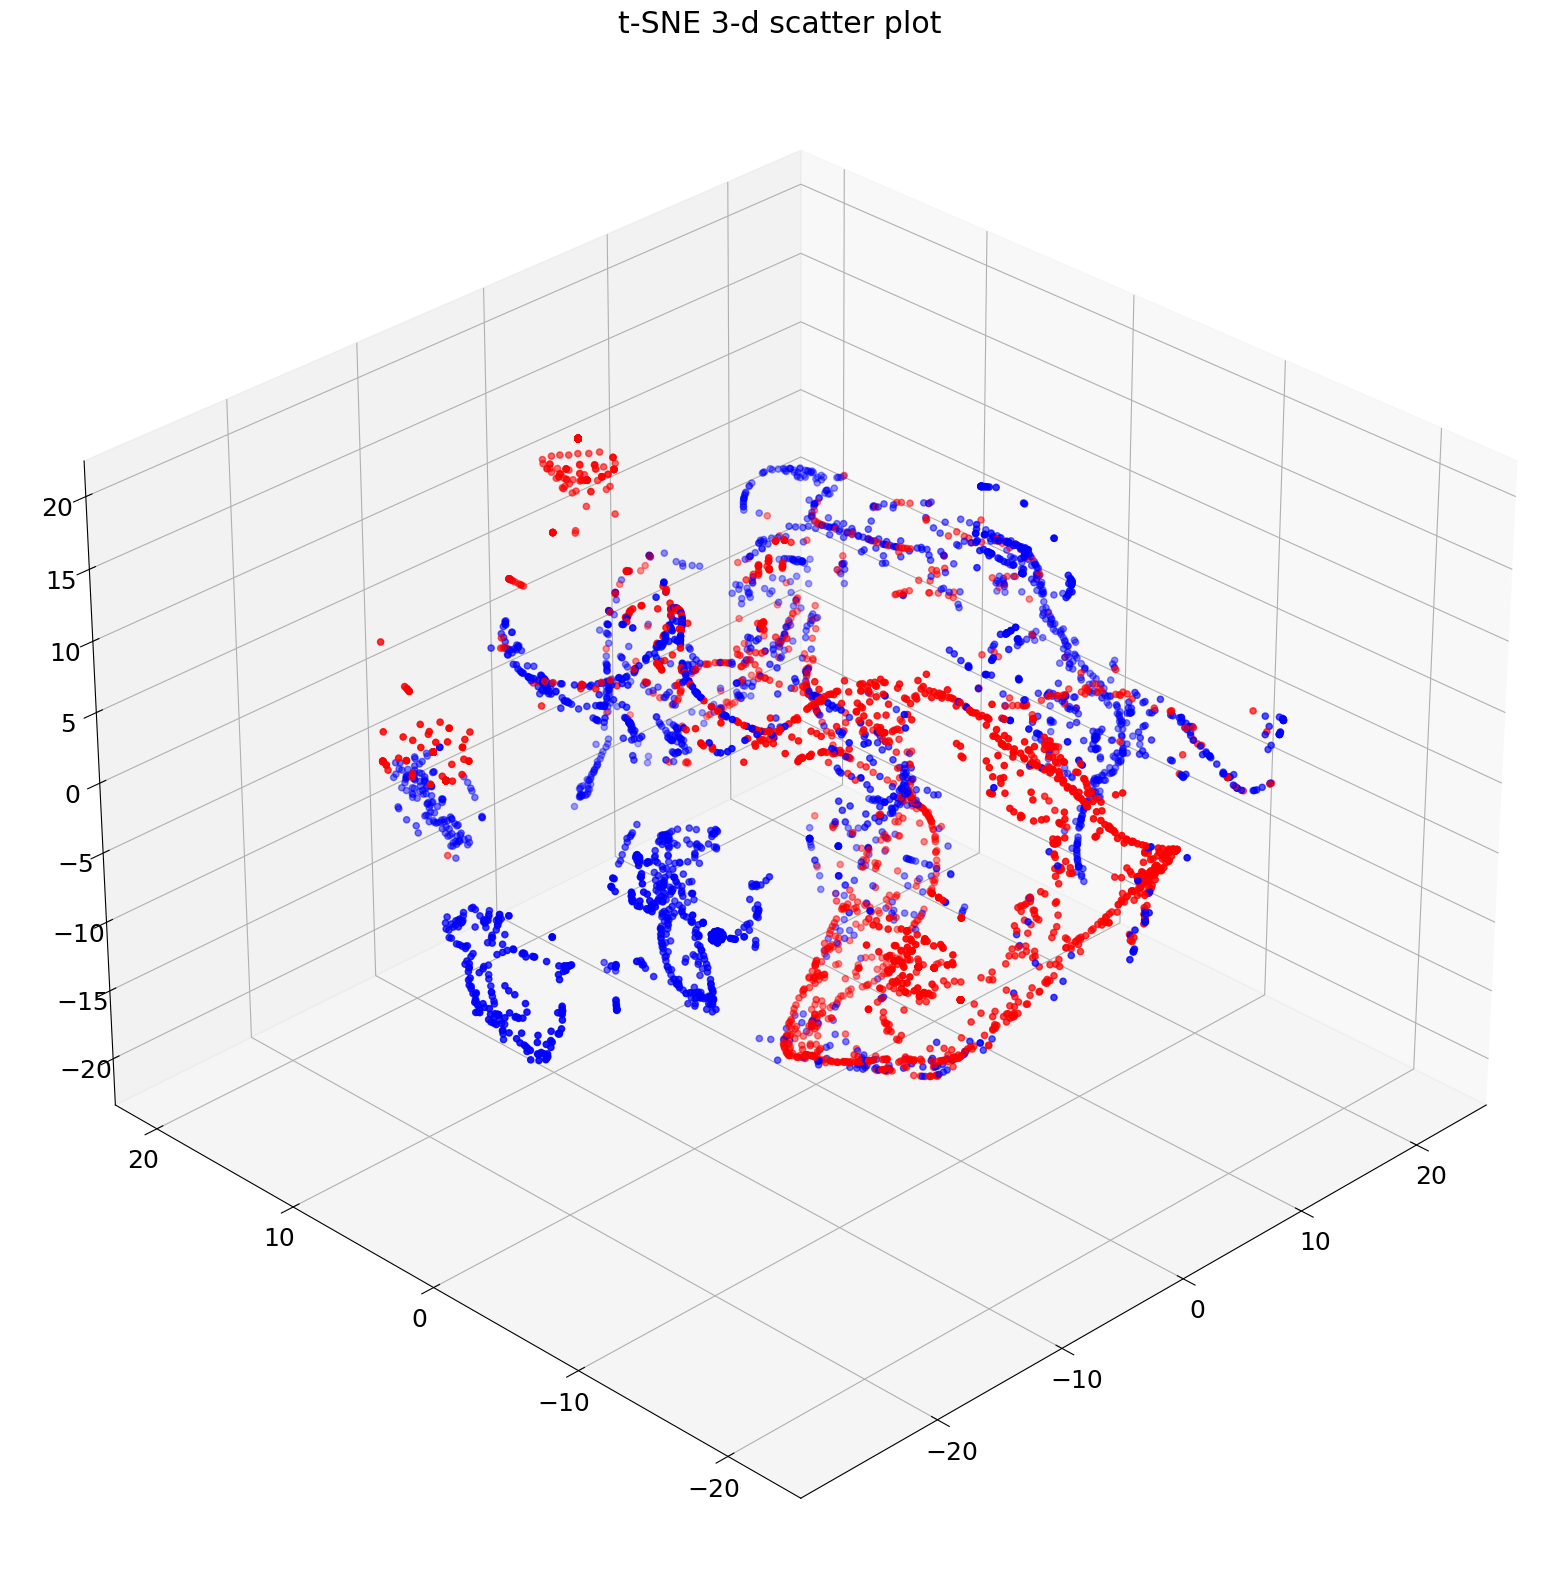

In [6]:
# Оригинальный код представлен https://github.com/sfarrugia15/Ethereum_Fraud_Detection/blob/master/Account_Stats/Account_Clustering.py#L106

def TSNE_plot_3D(df):
    tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=1000, n_iter_without_progress=20)
    
    X = df.loc[:, df.columns != 'FLAG']
    Y = df['FLAG']
    
    tsne_results = tsne.fit_transform(X)
    
    if tsne_results.shape[1] >= 3:
        X['first_dimension'] = tsne_results[:, 0]
        X['second_dimension'] = tsne_results[:, 1]
        X['third_dimension'] = tsne_results[:, 2]
        
        colors = ['blue', 'red']
        fig = plt.figure(figsize=(20,20))
        plt.rcParams.update({'font.size': 18})
        ax = fig.add_subplot(111, projection='3d')  # Добавление трехмерного графика к заданной фигуре
        ax.scatter(X["first_dimension"], X["second_dimension"], X["third_dimension"], c=Y, marker='o', cmap=matplotlib.colors.ListedColormap(colors))
        ax.view_init(30, 225)
        plt.title('t-SNE 3-d scatter plot')
        plt.show()  # Отображение графика
    else:
        print("Не удалось построить график в 3D с текущими данными.")


TSNE_plot_3D(data_for_tsne)


Оба рисунка подчеркивают необходимость использования методов машинного обучения, которые помогут различить два двоичных класса, обеспечивая визуальное представление имеющихся данных.

### Метрики оценки эффективности модели 
Для большего понимания этого блока необходимо ознакомится с [материалом оценки качества в задачах классификации](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0%D1%85_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8).

> Общие понятия:
> * TP — true positive: классификатор верно отнёс объект к рассматриваемому классу.
> * TN — true negative: классификатор верно утверждает, что объект не принадлежит к рассматриваемому классу.
> * FP — false positive: классификатор неверно отнёс объект к рассматриваемому классу.
> * FN — false negative: классификатор неверно утверждает, что объект не принадлежит к рассматриваемому классу.

Для оценки эффективности модели использовалась кросс-валидация(cross-validation).

> [Кросс-валидация](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9A%D1%80%D0%BE%D1%81%D1%81-%D0%B2%D0%B0%D0%BB%D0%B8%D0%B4%D0%B0%D1%86%D0%B8%D1%8F) — процедура эмпирического оценивания обобщающей способности алгоритмов. С помощью кросс-валидации эмулируется наличие тестовой выборки, которая не участвует в обучении, но для которой известны правильные ответы.

Для подбора наилучших параметров в модели XGBoost таких как:
* learning rate
* n_estimators - the number of estimators
* max_depth - the maximum depth

использовался grid-search.

> [grid-search](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9D%D0%B0%D1%81%D1%82%D1%80%D0%BE%D0%B9%D0%BA%D0%B0_%D0%B3%D0%B8%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%B2) или поиск по сетке - принимает на вход модель и различные значения гиперпараметров (сетку гиперпараметров). Далее, для каждого возможного сочетания значений гиперпараметров, метод считает ошибку и в конце выбирает сочетание, при котором ошибка минимальна.

Наилучшие параметры(гиперпараметры) были определены с помощью таких метрик как:
* _Accuracy(точность)_ -  один из простейших показателей определения эффективности модели классификации. Говоря простым языком, это число правильных предсказаний по отношению ко всем доступным проверяемым примерам. То есть __Accuracy = (TP + TN) / ((FN + TP) + (TN + FP))__.
* _Sensitivity(Чувствительность)_ - позволяет нам определить долю реальных положительных результатов, которые были правильно идентифицированы. То есть __Sensitivity = TP / (FN + TP)__.
* _Specificity(Специфика)_ - используется для расчета частоты ложных срабатываний. То есть __Specificity = TN / (TN + FP)__.
* _[ROC(Receiver Operating Characteristic)-Curve](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0%D1%85_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8#ROC-.D0.BA.D1.80.D0.B8.D0.B2.D0.B0.D1.8F)_ - ROC представляет собой меру разделимости, выражающую способность модели различать классы, используя специфичность мы сожем построить кривую ROC. 
* _AUC(Area Under the Curve)_ - используется для численной оценки алгоритма, идеальный алгоритм имеет AUC, равный 1, худший — 0,5.

Алгоритм XGBoost обеспечивает вероятность того, что учетная запись является частью незаконного класса. Вирируя порог вероятности, с помощью которого определяется выход класса, генерируются варианты пар чувствительности и специфичности, которые мы используем для построения ROC-кривой и вычисления соответствующей площади под кривой(AUC). Чем выше AUC, тем выше точность нашей модели.

Учитывая риск, связанный с неправильной классификацией учетных записей, а также ее способность охватывать все критерии, связанные с производительностью модели, AUC считается более предпочтительным показателем для определения оптимальной модели XGBoost с различными конфигурациями.

### Результаты
Использовав grid-search для подбора наилучших параметров XGBoost описанных в предыдущем блоке и cross-validation для оценивания обобщающей способности алгоритма получены следующие данные:

In [7]:
# Разделение данных на классификатор и признаки классификатора
def get_data(data: pd.DataFrame):
    data = remove_fields(data.copy())
    data.fillna(0, inplace=True)
    Y = data['FLAG']
    X = data.loc[:, data.columns != 'FLAG']
    return X, Y

# Разделение данных на выборки для теста и тренировки модели
def prepare_dataset_split(X, Y, testSize):
    test_size = testSize

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y, shuffle=True)
    
    print("Size of Training: ", len(X_train))
    print("Size of Testing: ", len(X_test))
    
    return X_train, X_test, y_train, y_test

Starting stratified Cross-validation using XG-Boost
Best AUC: 0.993661 using {'max_depth': 4, 'n_estimators': 250}


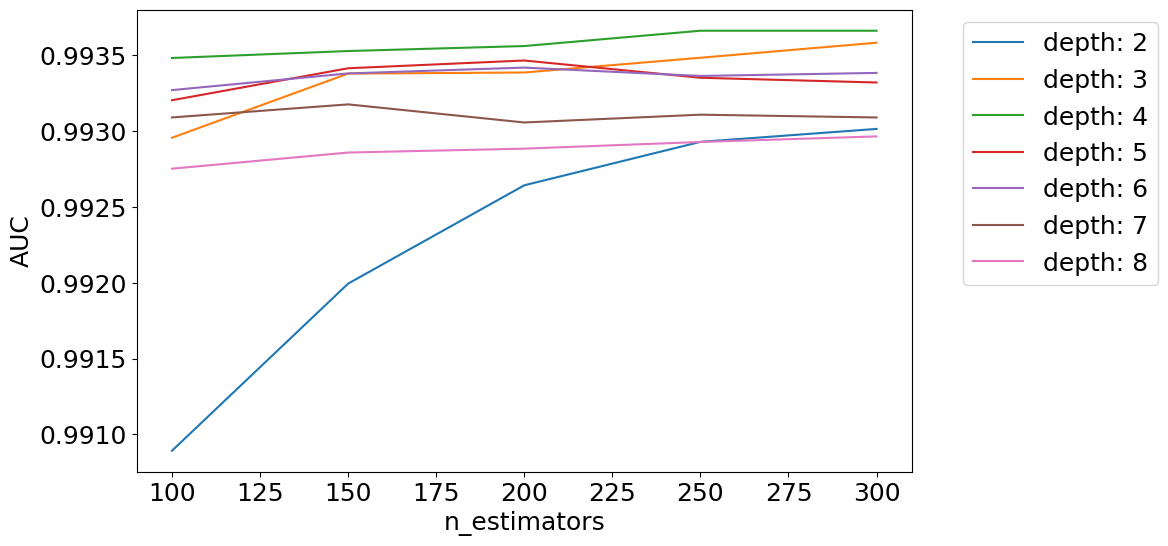

In [8]:
# Оригинальный код представлен https://github.com/sfarrugia15/Ethereum_Fraud_Detection/blob/master/XGBoost_Model/Final_XGBoost_Model.py

# Подбор лучших параметров для модели XGBoost
def XGBoost_best_param_checking(X, Y, n_folds):    
    print("Starting stratified Cross-validation using XG-Boost")
    
    model1 = xgb.XGBClassifier(learning_rate=0.2)
    max_depth = [2, 3, 4, 5, 6, 7, 8]
    n_estimators = [100, 150, 200, 250, 300]
    
    param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=7)
        
    results = GridSearchCV(
        model1, 
        param_grid, 
        cv=kfold,
        scoring='roc_auc', 
        n_jobs=6
    )

    grid_result = results.fit(X, Y)

    print("Best AUC: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    means = grid_result.cv_results_['mean_test_score']

    plt.figure(figsize=(10, 6))
    scores = np.array(means).reshape(len(max_depth), len(n_estimators))
    
    for i, value in enumerate(max_depth):
        plt.plot(n_estimators, scores[i], label='depth: ' + str(value))

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.show()

XGBoost_best_param_checking(*get_data(data.copy()), 10)

Показатель AUC использовался для определения оптимальной производительности модели. На графике представленном ниже показаны результаты вариаций кросс-валидации. Достигается оптимальный AUC 0.993661, с max_depth 4, n_estimators 250 и скоростью обучения(learning-rate) 0,2.

Стремясь лучше понять возможности обучения моделей, необходимо вывести логарифмические потери, а также ошибку классификации относительно количества итераций, выполняемых XGBoost.

Функция логарифмических потерь указывает цену, уплаченную за неточность прогнозов, сделанных с целью найти прямое отображение между векторным пространством и целевой функцией. 

Из двух графиков приведенных ниже можно отметить, что алгоритм обучения расходится примерно после 100 итераций.

Size of Training:  4212
Size of Testing:  469
[0]	validation_0-error:0.13557	validation_0-logloss:0.56841	validation_1-error:0.14925	validation_1-logloss:0.57063
[1]	validation_0-error:0.10066	validation_0-logloss:0.48810	validation_1-error:0.09808	validation_1-logloss:0.48641
[2]	validation_0-error:0.10043	validation_0-logloss:0.42488	validation_1-error:0.09808	validation_1-logloss:0.42273
[3]	validation_0-error:0.08642	validation_0-logloss:0.37938	validation_1-error:0.08316	validation_1-logloss:0.37775
[4]	validation_0-error:0.08523	validation_0-logloss:0.34014	validation_1-error:0.09168	validation_1-logloss:0.34222
[5]	validation_0-error:0.08025	validation_0-logloss:0.30816	validation_1-error:0.08316	validation_1-logloss:0.30935
[6]	validation_0-error:0.08191	validation_0-logloss:0.28145	validation_1-error:0.09168	validation_1-logloss:0.28308
[7]	validation_0-error:0.07669	validation_0-logloss:0.25800	validation_1-error:0.08742	validation_1-logloss:0.25973
[8]	validation_0-error:0.0

[10]	validation_0-error:0.06505	validation_0-logloss:0.21142	validation_1-error:0.07249	validation_1-logloss:0.21566
[11]	validation_0-error:0.05698	validation_0-logloss:0.19874	validation_1-error:0.06397	validation_1-logloss:0.20223
[12]	validation_0-error:0.05627	validation_0-logloss:0.18828	validation_1-error:0.06610	validation_1-logloss:0.18981
[13]	validation_0-error:0.05627	validation_0-logloss:0.17905	validation_1-error:0.06610	validation_1-logloss:0.18394
[14]	validation_0-error:0.05176	validation_0-logloss:0.17005	validation_1-error:0.06610	validation_1-logloss:0.17752
[15]	validation_0-error:0.04867	validation_0-logloss:0.16260	validation_1-error:0.06397	validation_1-logloss:0.17064
[16]	validation_0-error:0.04558	validation_0-logloss:0.15576	validation_1-error:0.06183	validation_1-logloss:0.16516
[17]	validation_0-error:0.04416	validation_0-logloss:0.14942	validation_1-error:0.05757	validation_1-logloss:0.15915
[18]	validation_0-error:0.04487	validation_0-logloss:0.14167	val

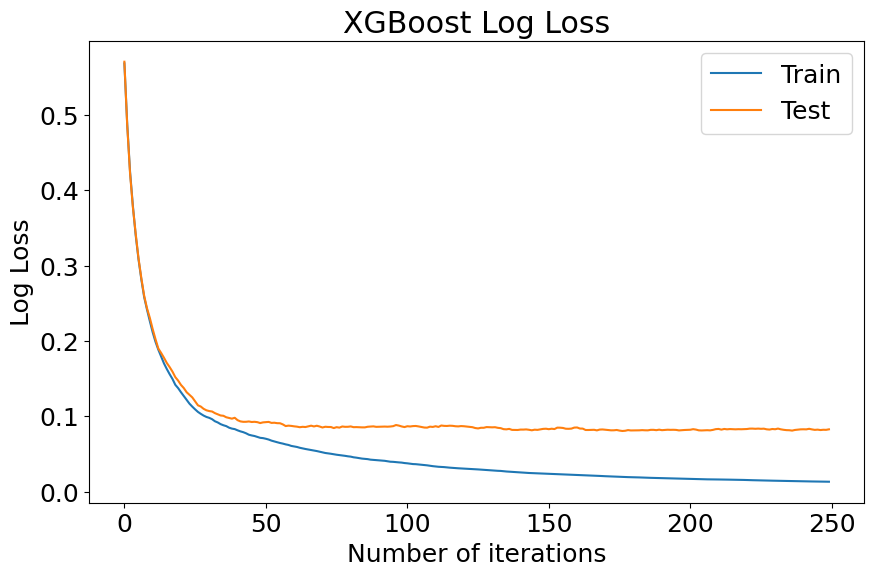

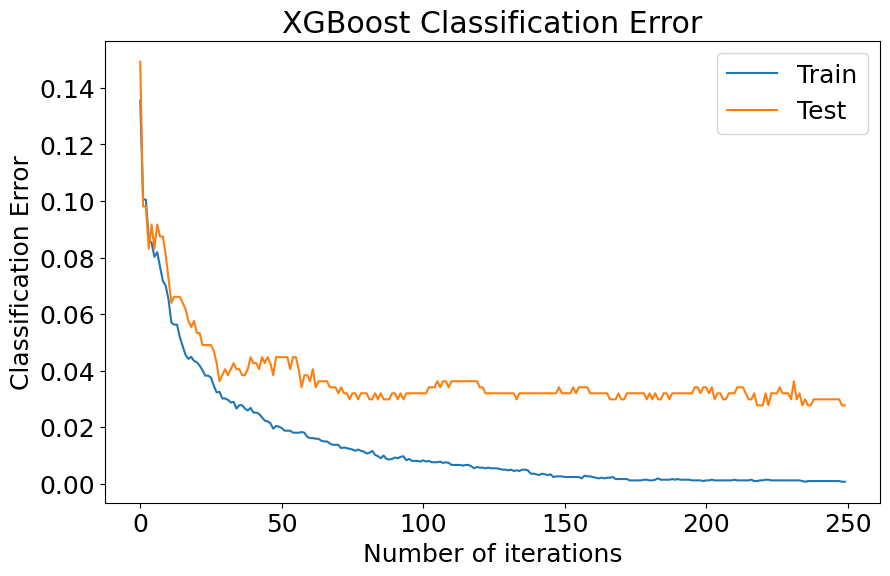

In [9]:
# Оригинальный код представлен https://github.com/sfarrugia15/Ethereum_Fraud_Detection/blob/master/XGBoost_Model/Final_XGBoost_Model.py#L383

def XGBoost_Classifier(X_train, y_train, X_test, y_test):
    model = xgb.XGBClassifier(
        max_depth=4,
        subsample=0.5,
        objective='binary:logistic',
        n_estimators=250,
        learning_rate=0.2,
        eval_metric=["error", "logloss"]
    )
    
    eval_set = [(X_train, y_train), (X_test, y_test)]

    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=True
    )

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))


    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    
    # plot log loss
    plt.figure(figsize=(10, 6))  # Adjust size of the plot
    plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
    plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
    plt.legend()
    plt.ylabel('Log Loss')
    plt.xlabel('Number of iterations')
    plt.title('XGBoost Log Loss')
    plt.show()
    
    # plot classification error
    plt.figure(figsize=(10, 6))  # Adjust size of the plot
    plt.plot(x_axis, results['validation_0']['error'], label='Train')
    plt.plot(x_axis, results['validation_1']['error'], label='Test')
    plt.legend()
    plt.ylabel('Classification Error')
    plt.xlabel('Number of iterations')
    plt.title('XGBoost Classification Error')
    plt.show()

X_train, X_test, y_train, y_test = prepare_dataset_split(*get_data(data.copy()), 0.1)
XGBoost_Classifier(X_train, y_train, X_test, y_test)

Для понимания того, правильно ли модель выдает результаты того является ли учетная запись преступной или нет, понадобится матрица ошибок. 

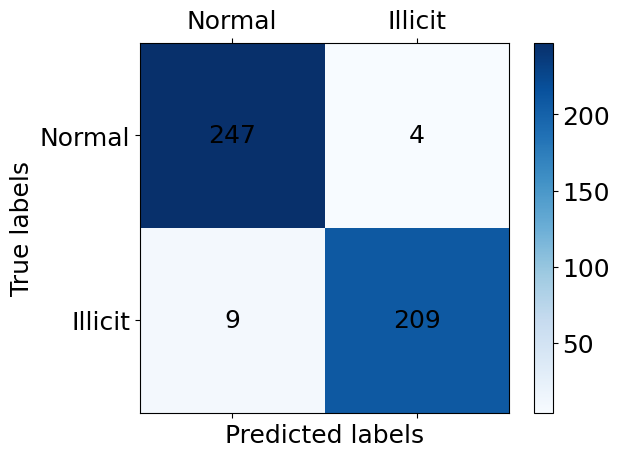

In [10]:
# Функция для построения матрицы ошибок
def plot_confusion_matrix(X_train, y_train, X_test, y_test):
    model = xgb.XGBClassifier(
        max_depth=4,
        subsample=0.5,
        objective='binary:logistic',
        n_estimators=250,
        learning_rate=0.2,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots()
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Добавляем надписи для ячеек
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')

    # Задаем позиции и подписи для делений на осях
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Normal', 'Illicit'])
    ax.set_yticklabels(['Normal', 'Illicit'])

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

    plt.show()


plot_confusion_matrix(X_train, y_train, X_test, y_test)

Модель в среднем выдала 4 ложноположительных результатов и 9 ложноотрицательных результатов. Они представляют собой количество аккаунтов, которые модель классифицировала как нормальные вместо незаконных или незаконные вместо нормальных соответственно.

Хотя это и не идеально, но основным интересом является обнаружение незаконных аккаунтов.

Также не лишним будет вывод важности признаков в порядке возрастная, чтобы посмотреть на что чаще всего обращает внимание модель.

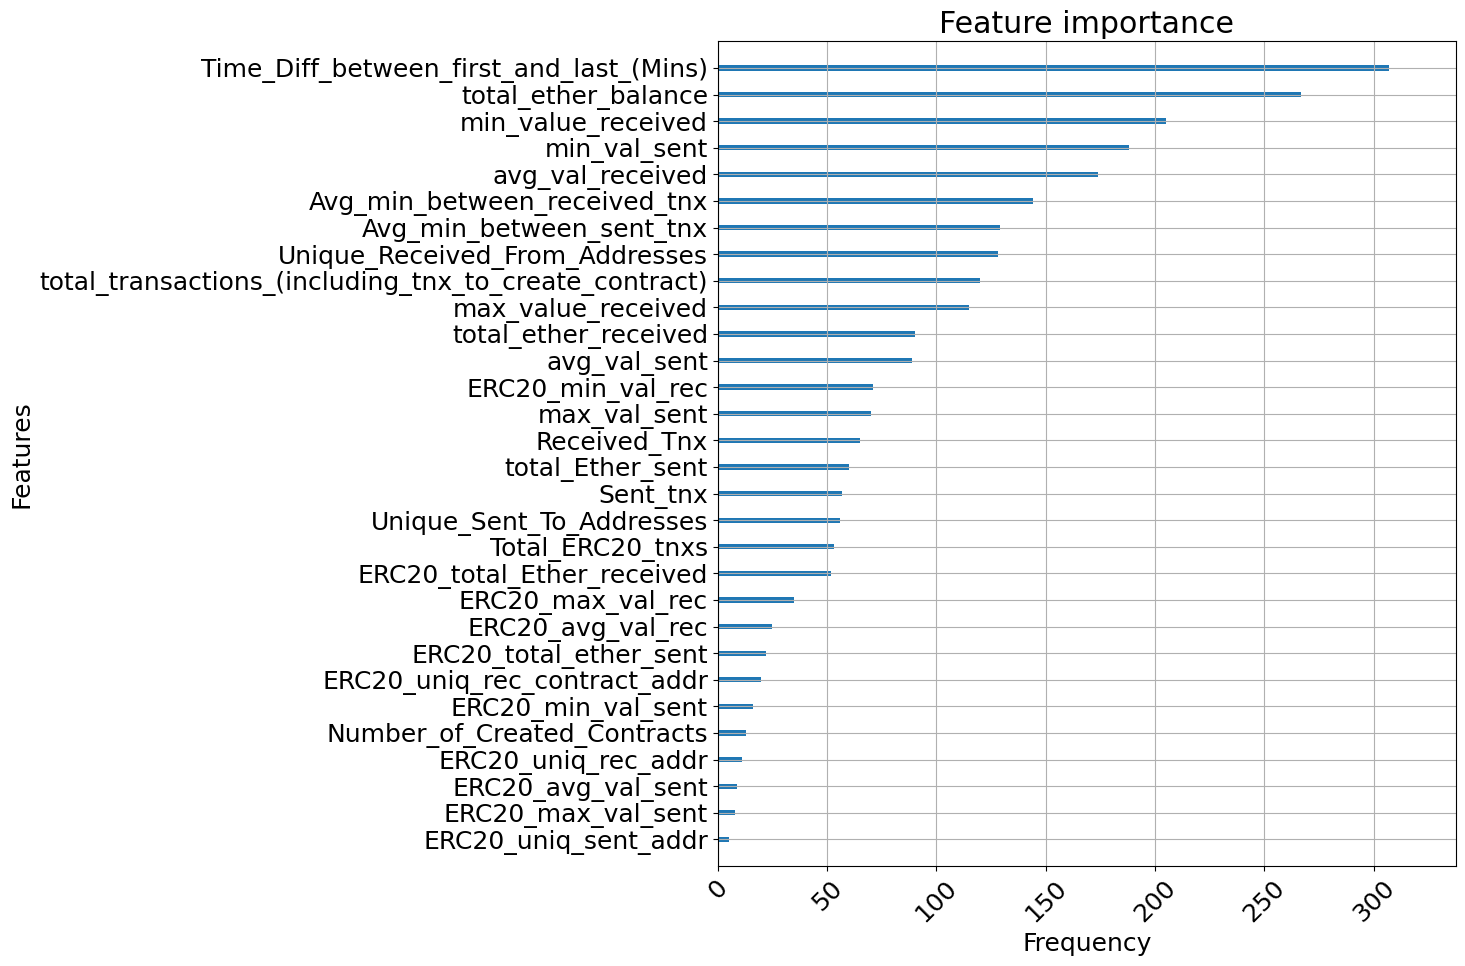

In [11]:
# Оригинальный код представлен https://github.com/sfarrugia15/Ethereum_Fraud_Detection/blob/master/XGBoost_Model/Final_XGBoost_Model.py

# Функция вывода важности признаков
def plot_xgb_feature_importance(X_train, y_train, X_test, y_test):
    model = xgb.XGBClassifier(
        max_depth=4,
        subsample=0.5,
        objective='binary:logistic',
        n_estimators=250,
        learning_rate=0.2,
        eval_metric=["error", "logloss"]
    )

    model.fit(
        X_train, y_train,
    )

    ax = xgb.plot_importance(model, importance_type="weight", show_values=False, xlabel="Frequency")
    
    ax.figure.set_figwidth(15)
    ax.figure.set_figheight(10)
    
    plt.xticks(rotation=45) 
    plt.tight_layout() 
    plt.show()  

plot_xgb_feature_importance(X_train, y_train, X_test, y_test)

Accuracy: 0.9722814498933902
Sensitivity: 0.9587155963302753
Specificity: 0.9840637450199203
AUC: 0.9961804159508755


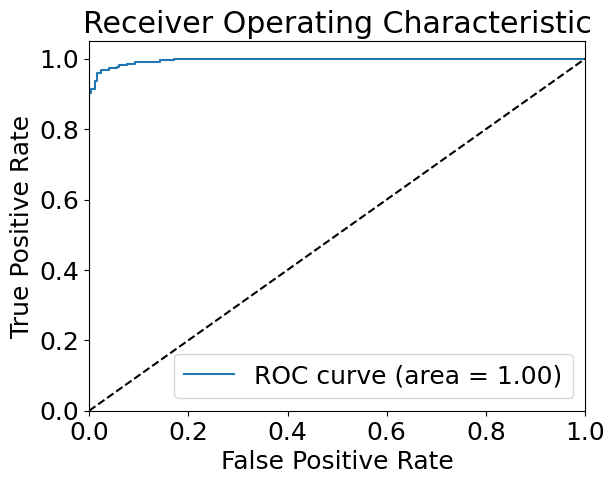

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['error', 'logloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [12]:
def evaluate_model(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(
        max_depth=4,
        subsample=0.5,
        objective='binary:logistic',
        n_estimators=250,
        learning_rate=0.2,
        eval_metric=["error", "logloss"]
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    
    specificity = recall_score(y_test, y_pred, pos_label=0)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f'Accuracy: {accuracy}')
    print(f'Sensitivity: {sensitivity}')
    print(f'Specificity: {specificity}')
    print(f'AUC: {auc}')

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return model

evaluate_model(X_train, X_test, y_train, y_test)

## Выгрузка модели
Для переиспользования в своей бизнес-логике я выгружу обученную модель и буду ее использовать для определения мошеннических транзакций в сети Ethereum 

In [13]:
model = xgb.XGBClassifier(
    max_depth=4,
    subsample=0.5,
    objective='binary:logistic',
    n_estimators=250,
    learning_rate=0.2,
    eval_metric=["error", "logloss"]
)

model.fit(X_train, y_train)

model.save_model('./cli/model.json')